# **Impacto no uso de People Analytics em decisões organizacionais para identificação de talentos**

**Objetivo:** Este notebook objetiva apresentar os experimentos para a criação de um **Modelo de Classificação**, vinculado ao Trabalho de Conclusão de Curso para Data Science and Analytics, junto a USP-Esalq, utilizando a metodologia CRISP-DM, desde sua fase de Entendimento dos Dados à última etapa de Implantação. 

**Experimentos**: As testagens considerarão o uso de três modelagens: Regressão Logística, Árvore de Decisão e Random Forest. As escolhas destes algoritmos se deram justamente pela complementação entre eles, além da facilidade de uso e interpretabilidade dos modelos. A Regressão Logística é fácil de interpretar e mostra como cada variável impacta a chance de promoção. A Árvore de Decisão gera regras simples e visuais que facilitam entender as decisões. Já o Random Forest é mais robusto, melhorando a precisão e ajudando a evitar erros comuns em modelos mais simples. Desta forma, se torna possível analisar e comparar de forma clara a performance de cada um deles, auxiliando na escolha do modelo "vencedor".

**Link Dataset:** https://www.kaggle.com/datasets/bhrt97/hr-analytics-classification

*Para acessar a documentação do projeto, com os insights, instruções e resultados obtidos, acesse o arquivo README.md deste repositório*

## 📘 Dicionário de Variáveis

| Nome da Variável       | Significado                                                                                           |
|------------------------|-------------------------------------------------------------------------------------------------------|
| **matricula**          | Identificador único do(a) colaborador(a) na empresa.                                                  |
| **departamento**       | Departamento ou área em que o(a) colaborador(a) atua (ex: Vendas, Tecnologia, RH).                   |
| **regiao**             | Região geográfica de atuação do(a) colaborador(a) (sem ordem ou hierarquia específica).               |
| **escolaridade**       | Nível educacional alcançado pelo(a) colaborador(a) (ex: Graduação, Pós-graduação, etc.).             |
| **genero**             | Gênero do(a) colaborador(a), geralmente categorizado como "Masculino" ou "Feminino".                 |
| **canal_recrutamento** | Canal através do qual o(a) colaborador(a) foi recrutado(a) (ex: Recrutamento Interno, Agência).      |
| **qtd_treinamentos**   | Número de treinamentos (técnicos ou comportamentais) realizados no ano anterior.                      |
| **idade**              | Idade do(a) colaborador(a), em anos.                                                                  |
| **avaliacao_anterior** | Nota de desempenho atribuída ao(à) colaborador(a) no ano anterior (geralmente em uma escala de 1 a 5).|
| **tempo_empresa**      | Tempo de serviço na empresa, em anos completos.                                                       |
| **kpis_atingidos**     | Indicador binário: 1 se mais de 80% dos KPIs (indicadores de performance) foram atingidos; 0 caso contrário. |
| **premios**            | Indicador binário: 1 se o(a) colaborador(a) ganhou algum prêmio no ano anterior; 0 caso contrário.    |
| **media_treinamento**  | Nota média obtida nos treinamentos atuais (avaliações de desempenho nos cursos realizados).           |
| **promovido**          | Variável alvo (target): 1 se o(a) colaborador(a) foi recomendado(a) para promoção; 0 caso contrário.  |


## Importar Bibliotecas

In [1]:
# ============================================================
# 1. Importação de bibliotecas para manipulação dos dados e plots 
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from modulo_graficos import grafico_movimentacao_promovidos  # Função customizada do projeto
import seaborn as sns
from scipy.stats import chi2_contingency
from IPython.display import display, HTML

# ============================================================
# 2. Importação de bibliotecas relacionadas à machine learning
# ============================================================

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score, cross_validate, GridSearchCV
)
from sklearn.metrics import (
    make_scorer, precision_score, f1_score, roc_auc_score, roc_curve,
    recall_score, fbeta_score, confusion_matrix, classification_report,
    ConfusionMatrixDisplay, precision_recall_curve, auc
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
import optuna

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

import joblib  # Para salvar e carregar modelos

In [2]:
# ============================================================
# 3. Ajustes visuais para exibição das tabelas
# ============================================================

pd.set_option('display.max_colwidth', None)     # Exibe o conteúdo completo das colunas
pd.set_option('display.max_rows', None)         # Exibe todas as linhas da tabela
pd.set_option('display.max_columns', None)      # Exibe todas as colunas da tabela
pd.set_option('display.float_format', '{:.2f}'.format)  # Exibe números decimais com 2 casas

## Input dos Dados

A base de dados disponibilizada pelo Kaggle está dividida em dois arquivos: treino e teste. 

Seguirei, portanto, a seguinte abordagem:

- A base de treino será utilizada para treinamento e validação do modelo (usando técnicas como validação cruzada ou divisão em treino/validação).
- A base de teste será utilizada apenas posteriormente para geração das previsões finais, pois seus rótulos são ocultos (avaliação cega).

A abordagem segue desta forma, pois visa garantir que o modelo não tenha acesso a dados do conjunto de teste durante o treinamento, evitando vazamento de informação e garantindo uma avaliação justa.

In [3]:
# ============================================================
# 4. Carrego os dados e verifico suas dimensões iniciais
# ============================================================

df_treino = pd.read_csv("dataset/train_hr_class.csv")
df_teste = pd.read_csv("dataset/test_hr_class.csv")  # Base sem target, usada apenas para validação

print(f"DF Treino: {df_treino.shape}")
print(f"DF Teste: {df_teste.shape}")

DF Treino: (54808, 14)
DF Teste: (23490, 13)


In [4]:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


In [5]:
df_treino.head(1)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.00,8,1,0,49,0


In [6]:
df_teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23490 entries, 0 to 23489
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           23490 non-null  int64  
 1   department            23490 non-null  object 
 2   region                23490 non-null  object 
 3   education             22456 non-null  object 
 4   gender                23490 non-null  object 
 5   recruitment_channel   23490 non-null  object 
 6   no_of_trainings       23490 non-null  int64  
 7   age                   23490 non-null  int64  
 8   previous_year_rating  21678 non-null  float64
 9   length_of_service     23490 non-null  int64  
 10  KPIs_met >80%         23490 non-null  int64  
 11  awards_won?           23490 non-null  int64  
 12  avg_training_score    23490 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 2.3+ MB


In [7]:
df_teste.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,NaN,1,1,0,77
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.00,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.00,4,0,0,47
3,38562,Procurement,region_2,Bachelor's,f,other,3,31,2.00,9,0,0,65
4,64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4.00,7,0,0,61


## Preparação dos Dados

### Tratamento e Limpeza dos Dados

Nesta seção, realizarei importantes etapas de tratamento de limpeza dos dados, tais como:

- Renomeio de colunas para Português-BR, a fim de facilitar a manipulação e compreensão dos dados
- Verificação de duplicidades
- Analisar o tipo dos dados, para eventuais conversões (caso necessário)
- Verificação de valores nulos e o seu devido tratamento

#### Renomear Variáveis

In [8]:
# ============================================================
# 5. Renomeio as colunas para o padrão em português
# ============================================================

mapa_colunas_treino = {
    "employee_id": "matricula", "department": "departamento", "region": "regiao",
    "education": "escolaridade", "gender": "genero", "recruitment_channel": "canal_recrutamento",
    "no_of_trainings": "qtd_treinamentos", "age": "idade", "previous_year_rating": "avaliacao_anterior",
    "length_of_service": "tempo_empresa", "KPIs_met >80%": "kpis_atingidos",
    "awards_won?": "premios", "avg_training_score": "media_treinamento", "is_promoted": "promovido"
}

mapa_colunas_teste = {col: mapa_colunas_treino[col] for col in df_teste.columns}  # Apenas colunas existentes no teste

df_treino = df_treino.rename(columns=mapa_colunas_treino)
df_teste = df_teste.rename(columns=mapa_colunas_teste)

df_treino.head(1)

,matricula,departamento,regiao,escolaridade,genero,canal_recrutamento,qtd_treinamentos,idade,avaliacao_anterior,tempo_empresa,kpis_atingidos,premios,media_treinamento,promovido
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.00,8,1,0,49,0


In [9]:
# ============================================================
# 6. Separo variáveis independentes (X) e alvo (y)
# ============================================================

X = df_treino.drop(["promovido", "matricula"], axis=1)
y = df_treino["promovido"]

#### Duplicidade

In [10]:
if df_treino['matricula'].duplicated().any():
    print("Existem duplicados")
else:
    print("Não há matrículas duplicadas")

Não há matrículas duplicadas


#### Nulos

In [11]:
df_treino.isnull().sum()[df_treino.isnull().sum() > 0]

escolaridade          2409
avaliacao_anterior    4124
dtype: int64

In [12]:
print(df_treino['matricula'].count())

54808


In [13]:
df_treino['escolaridade'].value_counts()

escolaridade
Bachelor's          36669
Master's & above    14925
Below Secondary       805
Name: count, dtype: int64

In [14]:
df_treino['avaliacao_anterior'].value_counts()

avaliacao_anterior
3.00    18618
5.00    11741
4.00     9877
1.00     6223
2.00     4225
Name: count, dtype: int64

**Para este tratamento de dados, optarei pela imputação de valores fixos:**
- Avaliação Anterior: para quem não teve nota computada para avaliação anterior, igualaremos à zero (0)
- Escolaridade: para quem não tem registro sobre o nível de escolaridade, preencheremos com "No_Education"

In [15]:
# ============================================================
# 7. Funções de pré-processamento
# ============================================================

def tratar_tipos(df):
    for col in df.columns:
        try:
            df[col] = pd.to_numeric(df[col])
        except (ValueError, TypeError):
            pass
        if df[col].dtype == 'object' and df[col].nunique() / len(df) < 0.3: 
            df[col] = df[col].astype('category')
    colunas_categoricas = ['kpis_atingidos', 'premios', 'promovido']
    for col in colunas_categoricas:
        if col in df.columns:
            df[col] = df[col].astype('category')
    return df
    
def tratar_variaveis(df):
    df = df.copy()
    
    # Tratamento da escolaridade
    if 'escolaridade' in df.columns:
        if df['escolaridade'].dtype.name == 'category':
            if 'No_Education' not in df['escolaridade'].cat.categories:
                df['escolaridade'] = df['escolaridade'].cat.add_categories(['No_Education'])
        df['escolaridade'] = df['escolaridade'].fillna('No_Education')
    
    # Tratamento da avaliacao_anterior
    if 'avaliacao_anterior' in df.columns:
        # Criar variável indicadora antes da imputação
        df['tem_avaliacao_anterior'] = df['avaliacao_anterior'].notnull().astype(int)
        
        # Calcular a mediana apenas dos valores válidos (entre 1 e 5)
        mediana_valida = df.loc[df['avaliacao_anterior'].between(1, 5), 'avaliacao_anterior'].median()
        
        # Substituir os valores ausentes pela mediana calculada
        df['avaliacao_anterior'] = df['avaliacao_anterior'].fillna(mediana_valida)
    
    return df

transforma_tipos = FunctionTransformer(tratar_tipos)
transforma_variaveis = FunctionTransformer(tratar_variaveis)

## Modelagem

- Criação dos Pipelines
- Funções de Normalização/Padronização
- Testagem dos Algoritmos em Cross-Validation
- Escolha do Melhor Algoritmo
- Refinamento para melhora dos resultados

In [16]:
# ============================================================
# 8. Pipelines para variáveis numéricas e categóricas
# ============================================================

pipeline_numerico = Pipeline(steps=[
    ("imputacao", SimpleImputer(strategy="median")),
    ("padronizacao", StandardScaler())
])

pipeline_categorico = Pipeline(steps=[
    ("imputacao", SimpleImputer(strategy="most_frequent")),
    ("codificacao", OneHotEncoder(handle_unknown="ignore"))
])

# Optei por essa função, para ter uma identificação mais dinâmica dos tipos de variáveis
def identificar_tipos(df):
    df_tmp = tratar_tipos(df.copy())
    colunas_numericas = df_tmp.select_dtypes(include=['int64', 'float64']).columns.tolist()
    colunas_categoricas = df_tmp.select_dtypes(include=['object', 'category']).columns.tolist()
    return colunas_numericas, colunas_categoricas

colunas_numericas, colunas_categoricas = identificar_tipos(X)

preprocessador = ColumnTransformer(transformers=[
    ("numerico", pipeline_numerico, colunas_numericas),
    ("categorico", pipeline_categorico, colunas_categoricas)
])

In [17]:
# ============================================================
# 9. Pipeline final de pré-processamento
# ============================================================

pipeline_base = Pipeline(steps=[
    ("transforma_tipos", transforma_tipos),
    ("transforma_variaveis", transforma_variaveis),
    ("preprocessador", preprocessador)
])

In [18]:
# ============================================================
# 10. Função para avaliação dos modelos e função do modelo final (vencedor)
# ============================================================

def exibir_metricas(real, pred, proba):
    recall = recall_score(real, pred)
    precisao, recall_curve, _ = precision_recall_curve(real, proba)
    auc_pr = auc(recall_curve, precisao)
    f2 = fbeta_score(real, pred, beta=2)

    print(f"Recall: {recall:.4f}")
    print(f"AUCPR: {auc_pr:.4f}")
    print(f"F2 Score: {f2:.4f}")
    print("\nRelatório completo:\n", classification_report(real, pred))

    matriz_confusao = confusion_matrix(real, pred)
    ConfusionMatrixDisplay(matriz_confusao, display_labels=['não-promovido', 'promovido']).plot()

def avaliacao_completa(real, pred, proba, titulo="Avaliação do Modelo"): # Somente para o modelo Final
    # ========================
    # Métricas principais
    # ========================
    recall = recall_score(real, pred)
    precisao, recall_curve, _ = precision_recall_curve(real, proba)
    auc_pr = auc(recall_curve, precisao)
    f2 = fbeta_score(real, pred, beta=2)
    auc_roc = roc_auc_score(real, proba)

    print("="*60)
    print(f"{titulo}")
    print("="*60)
    print(f"Recall:     {recall:.4f}")
    print(f"F2 Score:   {f2:.4f}")
    print(f"AUC-PR:     {auc_pr:.4f}")
    print(f"AUC-ROC:    {auc_roc:.4f}")
    print("\nRelatório completo:\n", classification_report(real, pred))

    # ========================
    # Visualizações
    # ========================
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f"Avaliação Final - {titulo}", fontsize=16)

    # 1. Matriz de confusão normalizada
    matriz = confusion_matrix(real, pred, normalize="true")
    sns.heatmap(
        matriz, annot=True, fmt=".2f", cmap="Blues", cbar=False,
        xticklabels=["Não promovido", "Promovido"],
        yticklabels=["Não promovido", "Promovido"],
        ax=axes[0,0]
    )
    axes[0,0].set_title("Matriz de Confusão (normalizada)")
    axes[0,0].set_xlabel("Predito")
    axes[0,0].set_ylabel("Real")

    # 2. Curva Precision-Recall
    axes[0,1].plot(recall_curve, precisao, color="blue")
    axes[0,1].fill_between(recall_curve, precisao, alpha=0.2, color="blue")
    axes[0,1].set_title(f"Curva Precision-Recall (AUC={auc_pr:.3f})")
    axes[0,1].set_xlabel("Recall")
    axes[0,1].set_ylabel("Precisão")

    # 3. Curva ROC
    fpr, tpr, _ = roc_curve(real, proba)
    axes[1,0].plot(fpr, tpr, color="red", label=f"AUC={auc_roc:.3f}")
    axes[1,0].plot([0,1],[0,1], linestyle="--", color="gray")
    axes[1,0].set_title("Curva ROC")
    axes[1,0].set_xlabel("Taxa de Falsos Positivos")
    axes[1,0].set_ylabel("Taxa de Verdadeiros Positivos")
    axes[1,0].legend()

    # 4. Distribuição das probabilidades preditas
    sns.histplot(proba[real==0], bins=30, color="gray", label="Não promovido", alpha=0.6, ax=axes[1,1])
    sns.histplot(proba[real==1], bins=30, color="green", label="Promovido", alpha=0.6, ax=axes[1,1])
    axes[1,1].set_title("Distribuição das Probabilidades")
    axes[1,1].set_xlabel("Probabilidade prevista da classe positiva")
    axes[1,1].set_ylabel("Frequência")
    axes[1,1].legend()

    plt.tight_layout()
    plt.show()

In [19]:
# ============================================================
# 11. Definição dos modelos de classificação
# ============================================================

modelos = {
    "Regressao_Logistica": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "Arvore_Decisao": DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    "Random_Forest": RandomForestClassifier(random_state=42, class_weight="balanced")
}

In [20]:
# ============================================================
# 12. Testo os modelos com validação cruzada
# ============================================================

X_treino, X_val, y_treino, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

metricas = {
    "recall": "recall",
    "precisao": "precision",
    "f1": "f1",
    "roc_auc": "roc_auc"
}

for nome, modelo in modelos.items():
    pipeline = Pipeline(steps=[
        ("transforma_tipos", transforma_tipos),
        ("transforma_variaveis", transforma_variaveis),
        ("preprocessador", preprocessador),
        ("modelo", modelo)
    ])
    
    resultados = cross_validate(
        pipeline,
        X_treino,
        y_treino,
        cv=cv,
        scoring=metricas,
        return_train_score=False
    )
    
    print(f"\n=== {nome} (Validação Cruzada) ===")
    for metrica in metricas.keys():
        media = resultados[f'test_{metrica}'].mean()
        desvio = resultados[f'test_{metrica}'].std()
        print(f"{metrica}: {media:.4f} ± {desvio:.4f}")


=== Regressao_Logistica (Validação Cruzada) ===
recall: 0.8163 ± 0.0075
precisao: 0.2441 ± 0.0045
f1: 0.3758 ± 0.0053
roc_auc: 0.8762 ± 0.0014

=== Arvore_Decisao (Validação Cruzada) ===
recall: 0.4403 ± 0.0128
precisao: 0.4160 ± 0.0030
f1: 0.4277 ± 0.0065
roc_auc: 0.6914 ± 0.0056

=== Random_Forest (Validação Cruzada) ===
recall: 0.2758 ± 0.0149
precisao: 0.8234 ± 0.0285
f1: 0.4130 ± 0.0176
roc_auc: 0.8874 ± 0.0036



=== Avaliação do modelo: Regresso Logistica ===
Recall: 0.8223
AUCPR: 0.4705
F2 Score: 0.5569

Relatório completo:
               precision    recall  f1-score   support

           0       0.98      0.76      0.86     10028
           1       0.24      0.82      0.38       934

    accuracy                           0.77     10962
   macro avg       0.61      0.79      0.62     10962
weighted avg       0.92      0.77      0.82     10962



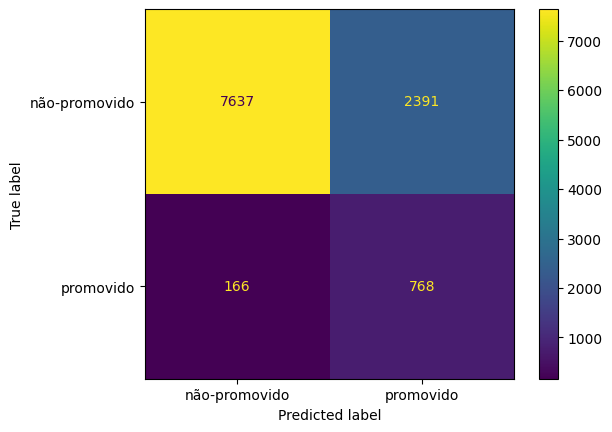

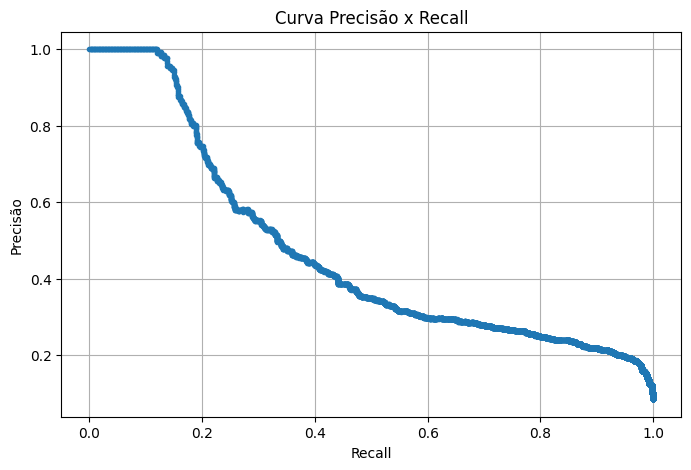

In [21]:
# ============================================================
# 13. Treino, validação e avaliação do melhor modelo da CV
# ============================================================

melhor_modelo = modelos["Regressao_Logistica"]
pipeline = Pipeline(steps=[
    ("transforma_tipos", transforma_tipos),
    ("transforma_variaveis", transforma_variaveis),
    ("preprocessador", preprocessador),
    ("modelo", melhor_modelo)
])

pipeline.fit(X_treino, y_treino)
predicoes = pipeline.predict(X_val)
probabilidades = pipeline.predict_proba(X_val)[:, 1]

print(f"\n=== Avaliação do modelo: Regresso Logistica ===")
exibir_metricas(y_val, predicoes, probabilidades)

precisoes, recalls, limiares = precision_recall_curve(y_val, probabilidades)

plt.figure(figsize=(8, 5))
plt.plot(recalls, precisoes, marker='.')
plt.xlabel("Recall")
plt.ylabel("Precisão")
plt.title("Curva Precisão x Recall")
plt.grid(True)
plt.show()

Melhor threshold pelo F2 (β=2): 0.48 | F2: 0.5623


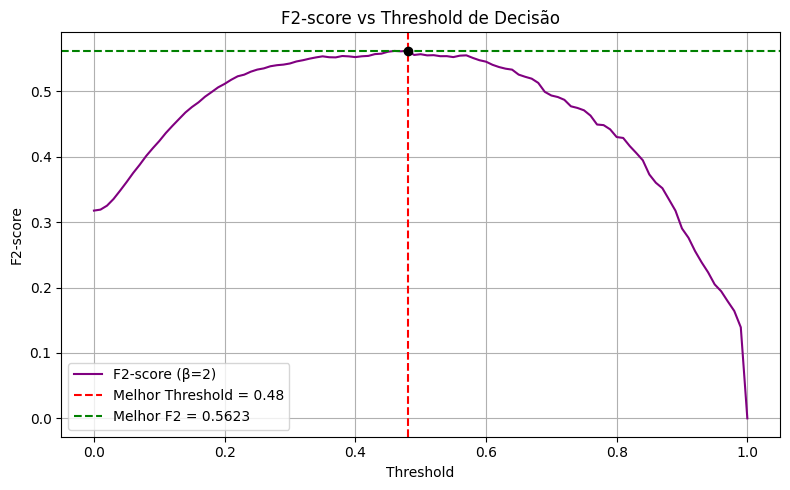

In [22]:
# ============================================================
# 14. Ajusto o threshold para melhorar a detecção dos promovidos
# ============================================================

# Parâmetros
beta = 2
thresholds = np.linspace(0, 1, 101)  # Caso ainda não esteja definido
melhor_f2 = 0
melhor_threshold = 0.5  # Valor inicial padrão
pontuacoes_f2 = []

# Cálculo do F2-score para cada threshold
for threshold in thresholds:
    previsoes = (probabilidades >= threshold).astype(int)
    f2 = fbeta_score(y_val, previsoes, beta=beta, zero_division=0)
    pontuacoes_f2.append(f2)
    if f2 > melhor_f2:
        melhor_f2 = f2
        melhor_threshold = threshold

print(f"Melhor threshold pelo F2 (β={beta}): {melhor_threshold:.2f} | F2: {melhor_f2:.4f}")

# Visualização do F2-score em função dos thresholds
plt.figure(figsize=(8, 5))
plt.plot(thresholds, pontuacoes_f2, label=f'F2-score (β={beta})', color='purple')
plt.axvline(x=melhor_threshold, color='red', linestyle='--', label=f'Melhor Threshold = {melhor_threshold:.2f}')
plt.axhline(y=melhor_f2, color='green', linestyle='--', label=f'Melhor F2 = {melhor_f2:.4f}')
plt.scatter(melhor_threshold, melhor_f2, color='black', zorder=5)

plt.xlabel('Threshold')
plt.ylabel('F2-score')
plt.title('F2-score vs Threshold de Decisão')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

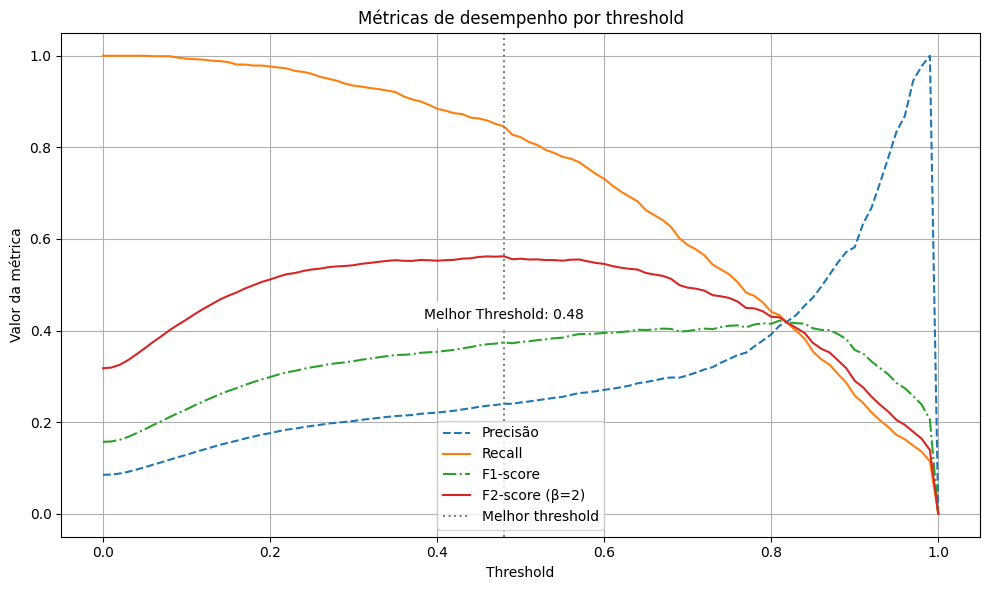

In [23]:
# ============================================================
# 14.1 Plot de precisão, recall, F1 e F2Score
# ============================================================

precisions = []
recalls = []
f1s = []
f2s = []

for t in thresholds:
    preds = (probabilidades >= t).astype(int)
    precisions.append(precision_score(y_val, preds, zero_division=0))
    recalls.append(recall_score(y_val, preds))
    f1s.append(f1_score(y_val, preds, zero_division=0))
    f2s.append(fbeta_score(y_val, preds, beta=2, zero_division=0))

plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions, label='Precisão', linestyle='--')
plt.plot(thresholds, recalls, label='Recall', linestyle='-')
plt.plot(thresholds, f1s, label='F1-score', linestyle='-.')
plt.plot(thresholds, f2s, label='F2-score (β=2)', linestyle='-')

ymax = plt.ylim()[1]

plt.axvline(melhor_threshold, color='gray', linestyle=':', label='Melhor threshold')
plt.text(melhor_threshold, ymax - 0.6, f'Melhor Threshold: {melhor_threshold:.2f}',
         ha='center', va='top', color='black', fontsize=10,
         backgroundcolor='white')

plt.xlabel('Threshold')
plt.ylabel('Valor da métrica')
plt.title('Métricas de desempenho por threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


=== Avaliação do modelo: Regresso Logistica - Threshold = 0.48 ===
Recall: 0.8458
AUCPR: 0.4705
F2 Score: 0.5623

Relatório completo:
               precision    recall  f1-score   support

           0       0.98      0.75      0.85     10028
           1       0.24      0.85      0.37       934

    accuracy                           0.76     10962
   macro avg       0.61      0.80      0.61     10962
weighted avg       0.92      0.76      0.81     10962



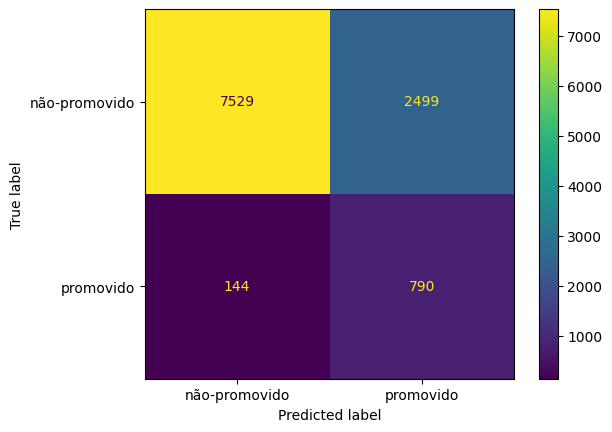

In [24]:
# ============================================================
# 14.2 Aplico o modelo final no dataset de teste
# ============================================================

preds_ajustadas = (probabilidades >= melhor_threshold).astype(int)

print(f"\n=== Avaliação do modelo: Regresso Logistica - Threshold = {melhor_threshold:.2f} ===")
exibir_metricas(y_val, preds_ajustadas, probabilidades)

## Tunning do Modelo

In [25]:
# ============================================================
# 15. Fine tuning com Optuna para otimizar hiperparâmetros
# ============================================================

def objetivo(trial):
    # Escolha do modelo a ser testado
    nome_modelo = trial.suggest_categorical("modelo", ["DecisionTree", "RandomForest", "LogisticRegression"])

    if nome_modelo == "DecisionTree":
        # Hiperparâmetros da Árvore de Decisão
        criterio = trial.suggest_categorical("criterion", ["gini", "entropy"])
        max_depth = trial.suggest_int("max_depth", 2, 50)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

        modelo = DecisionTreeClassifier(
            criterion=criterio,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            class_weight="balanced",
            random_state=42
        )

    elif nome_modelo == "RandomForest":
        # Hiperparâmetros do Random Forest
        n_estimators = trial.suggest_int("n_estimators", 50, 300, step=50)
        max_depth = trial.suggest_int("max_depth", 2, 50)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
        max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
        bootstrap = trial.suggest_categorical("bootstrap", [True, False])

        modelo = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            bootstrap=bootstrap,
            class_weight="balanced",
            random_state=42,
            n_jobs=-1
        )

    else:  # LogisticRegression
        # Hiperparâmetros da Regressão Logística
        C = trial.suggest_float("C", 1e-4, 10.0, log=True)
        penalty = trial.suggest_categorical("penalty", ["l1", "l2"])
        solver = "liblinear" if penalty == "l1" else "lbfgs"

        modelo = LogisticRegression(
            C=C,
            penalty=penalty,
            solver=solver,
            class_weight="balanced",
            random_state=42,
            max_iter=1000
        )

    # Pipeline com pré-processamento + undersampling + modelo
    pipeline = ImbPipeline(steps=[
        ("transforma_tipos", transforma_tipos),
        ("transforma_variaveis", transforma_variaveis),
        ("preprocessador", preprocessador),
        ("undersampler", RandomUnderSampler(random_state=42)),  
        ("modelo", modelo)
    ])

    # Validação cruzada estratificada
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Métrica de avaliação: recall da classe positiva (evitar falsos negativos)
    resultados = cross_val_score(
        pipeline,
        X_treino,
        y_treino,
        cv=cv,
        scoring="recall",
        n_jobs=-1
    )

    return resultados.mean()

# Estudo com Optuna
estudo = optuna.create_study(direction="maximize")
estudo.optimize(objetivo, n_trials=100, n_jobs=-1)

# Resultados
print("Número de trials finalizados:", len(estudo.trials))
print("Melhor recall médio:", estudo.best_value)
print("Melhores parâmetros:", estudo.best_params)

[I 2025-09-14 14:44:57,818] A new study created in memory with name: no-name-2f9aa7a2-e28f-43a5-9519-2aec959f187e
[I 2025-09-14 14:45:18,437] Trial 9 finished with value: 0.7142460817353418 and parameters: {'modelo': 'LogisticRegression', 'C': 0.0001702827434322156, 'penalty': 'l2'}. Best is trial 9 with value: 0.7142460817353418.
[I 2025-09-14 14:46:01,791] Trial 7 finished with value: 0.7062092875523541 and parameters: {'modelo': 'LogisticRegression', 'C': 0.0030753311774580215, 'penalty': 'l1'}. Best is trial 9 with value: 0.7142460817353418.
[I 2025-09-14 14:46:03,487] Trial 11 finished with value: 0.7986074772728088 and parameters: {'modelo': 'DecisionTree', 'criterion': 'entropy', 'max_depth': 44, 'min_samples_split': 6, 'min_samples_leaf': 7}. Best is trial 11 with value: 0.7986074772728088.
[I 2025-09-14 14:46:05,141] Trial 2 finished with value: 0.7737028543126931 and parameters: {'modelo': 'DecisionTree', 'criterion': 'gini', 'max_depth': 37, 'min_samples_split': 4, 'min_samp

Número de trials finalizados: 100
Melhor recall médio: 0.9437618211900327
Melhores parâmetros: {'modelo': 'RandomForest', 'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}


In [26]:
# ============================================================
# 16. Construção do modelo com melhor configuração do Optuna (v1)
# ============================================================

# Pego os melhores parâmetros encontrados no estudo
melhores_parametros = estudo.best_params
print("Melhor modelo encontrado:", melhores_parametros)

# Recrio o modelo com os hiperparâmetros ótimos encontrados
if melhores_parametros["modelo"] == "DecisionTree":
    melhor_modelo = DecisionTreeClassifier(
        criterion=melhores_parametros["criterion"],
        max_depth=melhores_parametros["max_depth"],
        min_samples_split=melhores_parametros["min_samples_split"],
        min_samples_leaf=melhores_parametros["min_samples_leaf"],
        class_weight="balanced",
        random_state=42
    )

elif melhores_parametros["modelo"] == "RandomForest":
    melhor_modelo = RandomForestClassifier(
        n_estimators=melhores_parametros["n_estimators"],
        max_depth=melhores_parametros["max_depth"],
        min_samples_split=melhores_parametros["min_samples_split"],
        min_samples_leaf=melhores_parametros["min_samples_leaf"],
        max_features=melhores_parametros["max_features"],
        bootstrap=melhores_parametros["bootstrap"],
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )

else:  # Regressão Logística
    melhor_modelo = LogisticRegression(
        C=melhores_parametros["C"],
        penalty=melhores_parametros["penalty"],
        solver="liblinear" if melhores_parametros["penalty"] == "l1" else "lbfgs",
        class_weight="balanced",
        max_iter=1000,
        random_state=42
    )

# Pipeline final com todas as transformações e o undersampling (RUS)
pipeline_final_optuna = ImbPipeline(steps=[
    ("transforma_tipos", transforma_tipos),
    ("transforma_variaveis", transforma_variaveis),
    ("preprocessador", preprocessador),
    ("undersampler", RandomUnderSampler(random_state=42)),  # Só age no treino!
    ("modelo", melhor_modelo)
])

# Treinamento do pipeline final com os dados de treino
pipeline_final_optuna.fit(X_treino, y_treino)

Melhor modelo encontrado: {'modelo': 'RandomForest', 'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}


Pipeline(steps=[('transforma_tipos',
                 FunctionTransformer(func=<function tratar_tipos at 0x00000203DEB481F0>)),
                ('transforma_variaveis',
                 FunctionTransformer(func=<function tratar_variaveis at 0x00000203DEB483A0>)),
                ('preprocessador',
                 ColumnTransformer(transformers=[('numerico',
                                                  Pipeline(steps=[('imputacao',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('padronizacao',
                                                                   Stand...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['departamento', 'regiao',
                                                   'escolaridade', 'genero',
                                                   'canal_recrutamento',
                                                   'kpis_atingidos',
                                                   'premios'])])),
                ('undersampler', RandomUnderSampler(random_state=42)),
                ('modelo',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        max_features=None, min_samples_leaf=2,
                                        min_samples_split=8, n_estimators=200,
                                        n_jobs=-1, random_state=42))])

Recall: 0.9475
AUCPR: 0.5720
F2 Score: 0.5683

Relatório completo:
               precision    recall  f1-score   support

           0       0.99      0.68      0.81     10028
           1       0.22      0.95      0.36       934

    accuracy                           0.71     10962
   macro avg       0.61      0.82      0.58     10962
weighted avg       0.93      0.71      0.77     10962



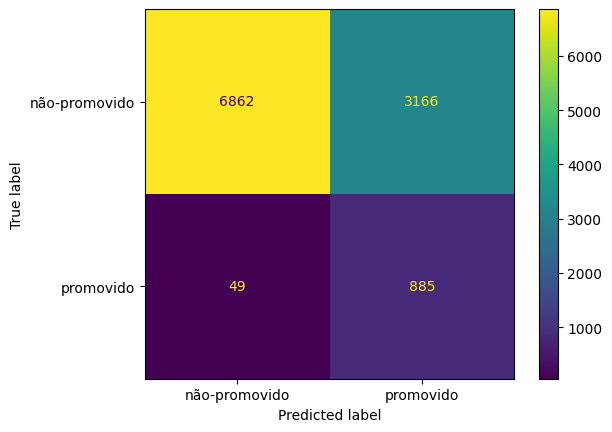

In [27]:
# Avalio o desempenho no conjunto de validação
y_pred_val = pipeline_final_optuna.predict(X_val)
y_proba_val = pipeline_final_optuna.predict_proba(X_val)[:, 1]

exibir_metricas(y_val, y_pred_val, y_proba_val)

Melhor threshold pelo F2 (β=2): 0.59 | F2: 0.5817


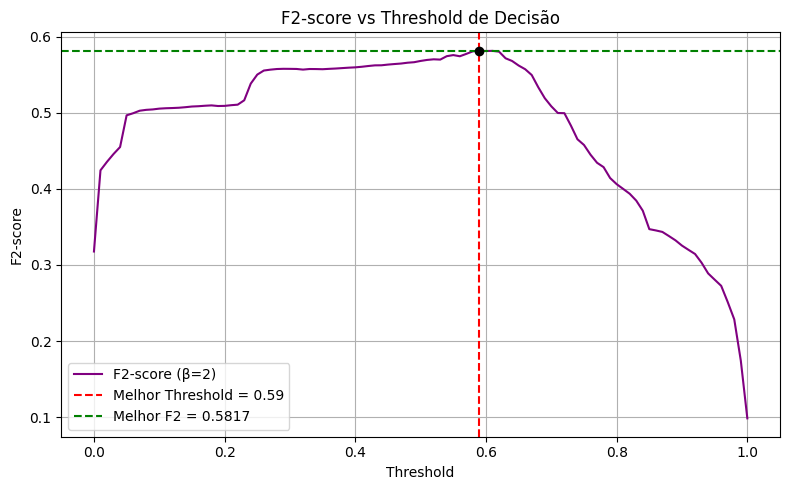

In [33]:
# ============================================================
# 17. Ajusto o threshold para melhorar a detecção dos promovidos
# ============================================================

# Parâmetros
beta = 2
thresholds = np.linspace(0, 1, 101)  # Caso ainda não esteja definido
melhor_f2 = 0
melhor_threshold = 0.5  # Valor inicial padrão
pontuacoes_f2 = []

# Cálculo do F2-score para cada threshold
for threshold in thresholds:
    previsoes = (y_proba_val >= threshold).astype(int)
    f2 = fbeta_score(y_val, previsoes, beta=beta, zero_division=0)
    pontuacoes_f2.append(f2)
    if f2 > melhor_f2:
        melhor_f2 = f2
        melhor_threshold = threshold

print(f"Melhor threshold pelo F2 (β={beta}): {melhor_threshold:.2f} | F2: {melhor_f2:.4f}")

# Visualização do F2-score em função dos thresholds
plt.figure(figsize=(8, 5))
plt.plot(thresholds, pontuacoes_f2, label=f'F2-score (β={beta})', color='purple')
plt.axvline(x=melhor_threshold, color='red', linestyle='--', label=f'Melhor Threshold = {melhor_threshold:.2f}')
plt.axhline(y=melhor_f2, color='green', linestyle='--', label=f'Melhor F2 = {melhor_f2:.4f}')
plt.scatter(melhor_threshold, melhor_f2, color='black', zorder=5)

plt.xlabel('Threshold')
plt.ylabel('F2-score')
plt.title('F2-score vs Threshold de Decisão')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

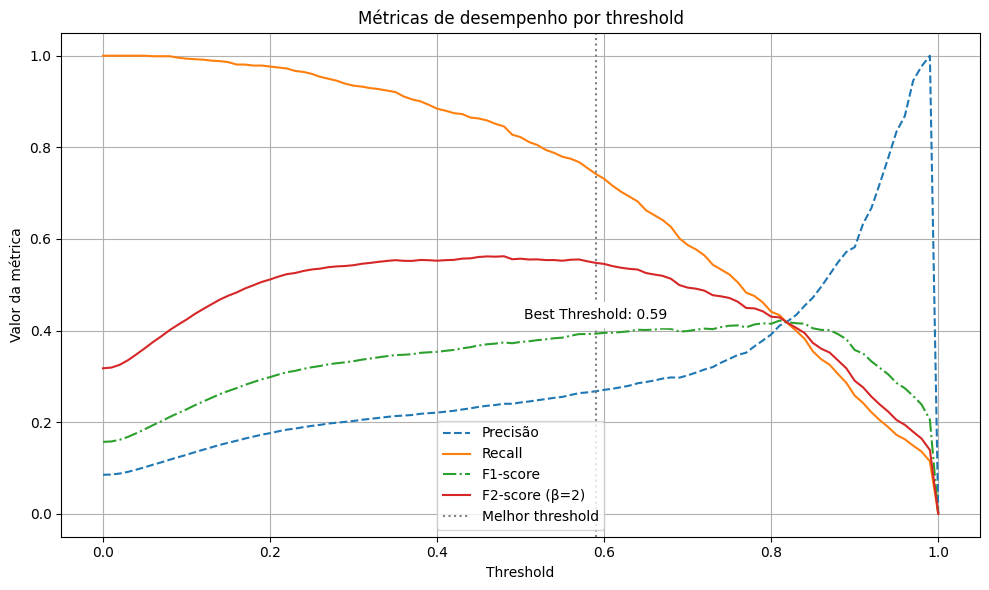

In [34]:
# ============================================================
# 17.1 Plot de precisão, recall, F1 e F2Score
# ============================================================

precisions = []
recalls = []
f1s = []
f2s = []

for t in thresholds:
    preds = (probabilidades >= t).astype(int)
    precisions.append(precision_score(y_val, preds, zero_division=0))
    recalls.append(recall_score(y_val, preds))
    f1s.append(f1_score(y_val, preds, zero_division=0))
    f2s.append(fbeta_score(y_val, preds, beta=2, zero_division=0))

plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions, label='Precisão', linestyle='--')
plt.plot(thresholds, recalls, label='Recall', linestyle='-')
plt.plot(thresholds, f1s, label='F1-score', linestyle='-.')
plt.plot(thresholds, f2s, label='F2-score (β=2)', linestyle='-')

ymax = plt.ylim()[1]

plt.axvline(melhor_threshold, color='gray', linestyle=':', label='Melhor threshold')
plt.text(melhor_threshold, ymax - 0.6, f'Best Threshold: {melhor_threshold:.2f}',
         ha='center', va='top', color='black', fontsize=10,
         backgroundcolor='white')

plt.xlabel('Threshold')
plt.ylabel('Valor da métrica')
plt.title('Métricas de desempenho por threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


=== Avaliação do modelo: Random Forest - Threshold = 0.59 ===
Recall: 0.8790
AUCPR: 0.5720
F2 Score: 0.5817

Relatório completo:
               precision    recall  f1-score   support

           0       0.99      0.75      0.85     10028
           1       0.25      0.88      0.39       934

    accuracy                           0.76     10962
   macro avg       0.62      0.81      0.62     10962
weighted avg       0.92      0.76      0.81     10962



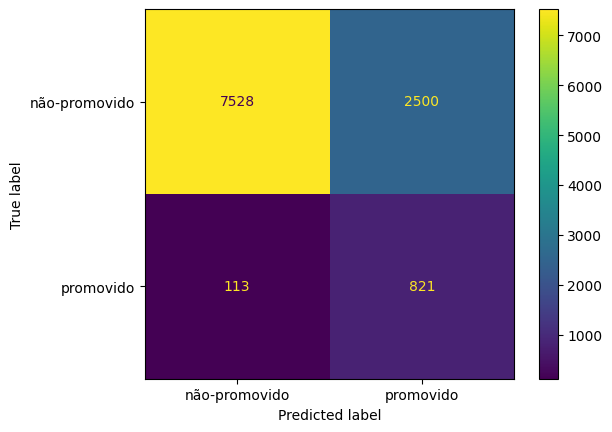

In [45]:
# ============================================================
# 18. Aplicar o melhor threshdold e verificar métricas
# ============================================================

preds_ajustadas = (y_proba_val >= melhor_threshold).astype(int)

print(f"\n=== Avaliação do modelo: Random Forest - Threshold = {melhor_threshold:.2f} ===")
exibir_metricas(y_val, preds_ajustadas, y_proba_val)

***
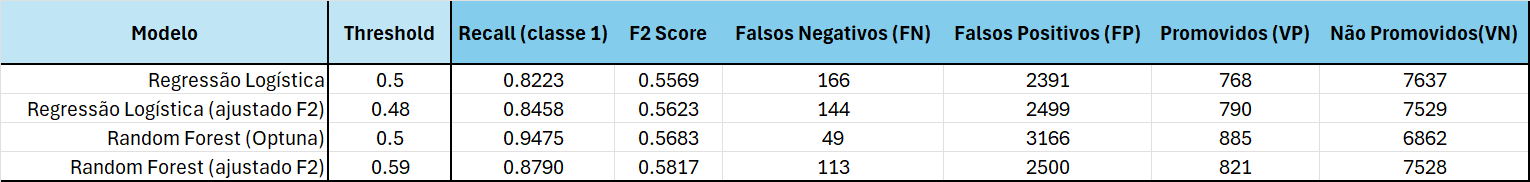
***

Após testes com diferentes algoritmos e thresholds, o modelo que mais se alinhou ao objetivo do projeto foi o **Random Forest otimizado com Optuna e com threshold padrão de 0.5**. A escolha baliza o intuito do projeto, que seria reduzir o custo na identificação Falsos Negativos, o que representa um risco reduzido de não identificar talentos/funcionários que deveriam ser promovidos. Então, apesar do ajuste no modelo RF para buscar um F2Score otimizado, o resultado na identificação dos Falsos Negativos mais que dobrou, sendo prejudicial ao objetivo do projeto.

Avaliação do Modelo
Recall:     0.9475
F2 Score:   0.5683
AUC-PR:     0.5720
AUC-ROC:    0.9001

Relatório completo:
               precision    recall  f1-score   support

           0       0.99      0.68      0.81     10028
           1       0.22      0.95      0.36       934

    accuracy                           0.71     10962
   macro avg       0.61      0.82      0.58     10962
weighted avg       0.93      0.71      0.77     10962



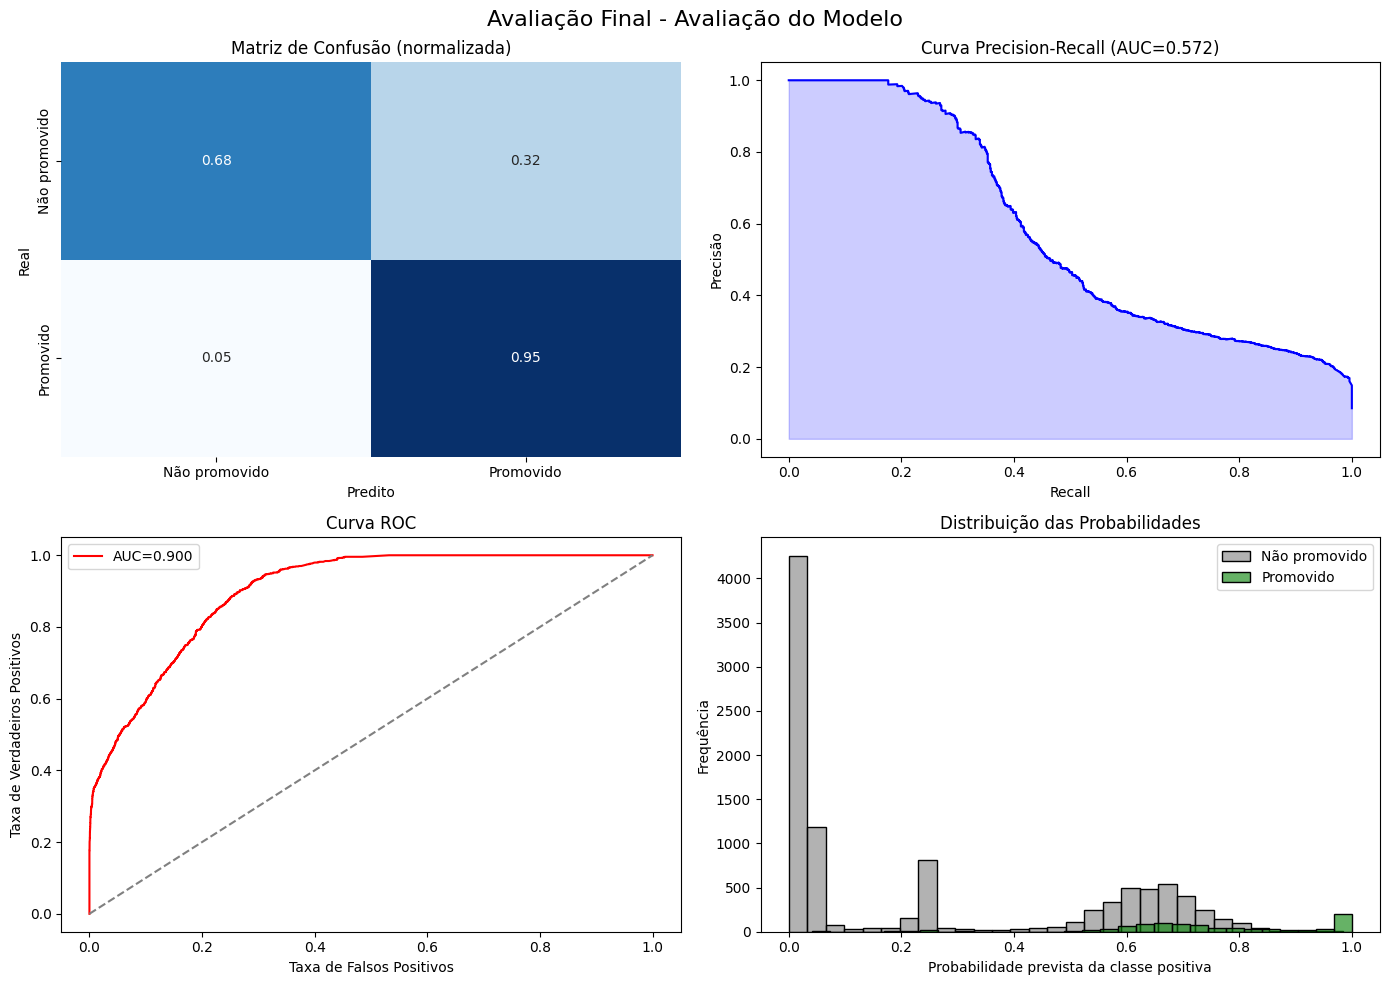

Recall: 0.9475
AUCPR: 0.5720
F2 Score: 0.5683

Relatório completo:
               precision    recall  f1-score   support

           0       0.99      0.68      0.81     10028
           1       0.22      0.95      0.36       934

    accuracy                           0.71     10962
   macro avg       0.61      0.82      0.58     10962
weighted avg       0.93      0.71      0.77     10962



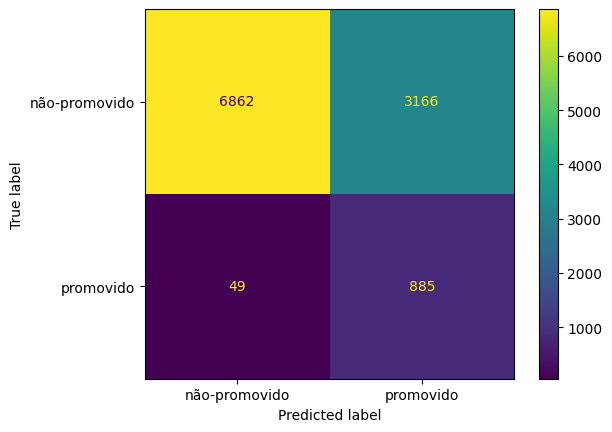

In [46]:
# Exibindo métricas completas para o modelo vencedor: Modelo 3 - Random Forest (Optuna)

avaliacao_completa(y_val, y_pred_val, y_proba_val)
exibir_metricas(y_val, y_pred_val, y_proba_val)

## Comparativo dos Modelos

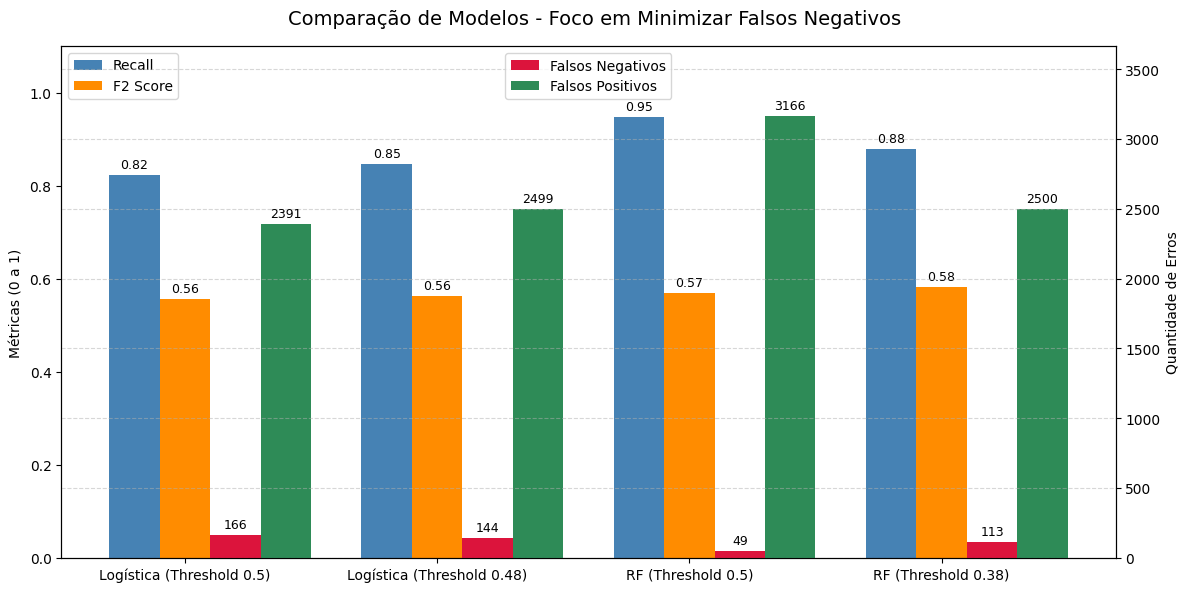

In [36]:
data = {
    'Modelo': [
        'Logística (Threshold 0.5)', 
        'Logística (Threshold 0.48)', 
        'RF (Threshold 0.5)', 
        'RF (Threshold 0.38)'
    ],
    'Recall': [0.8223, 0.8458, 0.9475, 0.8790],
    'F2 Score': [0.5569, 0.5623, 0.5683, 0.5817],
    'Falsos Negativos': [166, 144, 49, 113],
    'Falsos Positivos': [2391, 2499, 3166, 2500]
}

df = pd.DataFrame(data)
x = np.arange(len(df))

bar_width = 0.2

fig, ax1 = plt.subplots(figsize=(12, 6))

# Eixo Y para métricas (Recall e F2 Score)
ax1.set_ylabel('Métricas (0 a 1)')
ax1.set_ylim(0, 1.1)
bars1 = ax1.bar(x - bar_width, df['Recall'], width=bar_width, label='Recall', color='steelblue')
bars2 = ax1.bar(x, df['F2 Score'], width=bar_width, label='F2 Score', color='darkorange')

# Rótulos de valores nas barras (eixo Y1)
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'{height:.2f}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 5),
                     textcoords="offset points",
                     ha='center', fontsize=9)

# Eixo Y secundário para FN e FP
ax2 = ax1.twinx()
ax2.set_ylabel('Quantidade de Erros')
ax2.set_ylim(0, max(df['Falsos Positivos']) + 500)

bars3 = ax2.bar(x + bar_width, df['Falsos Negativos'], width=bar_width, label='Falsos Negativos', color='crimson')
bars4 = ax2.bar(x + 2*bar_width, df['Falsos Positivos'], width=bar_width, label='Falsos Positivos', color='seagreen')

# Rótulos de valores nas barras (eixo Y2)
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax2.annotate(f'{int(height)}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 5),
                     textcoords="offset points",
                     ha='center', fontsize=9)

# Configurações finais
plt.xticks(x, df['Modelo'])
fig.suptitle('Comparação de Modelos - Foco em Minimizar Falsos Negativos', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper center')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

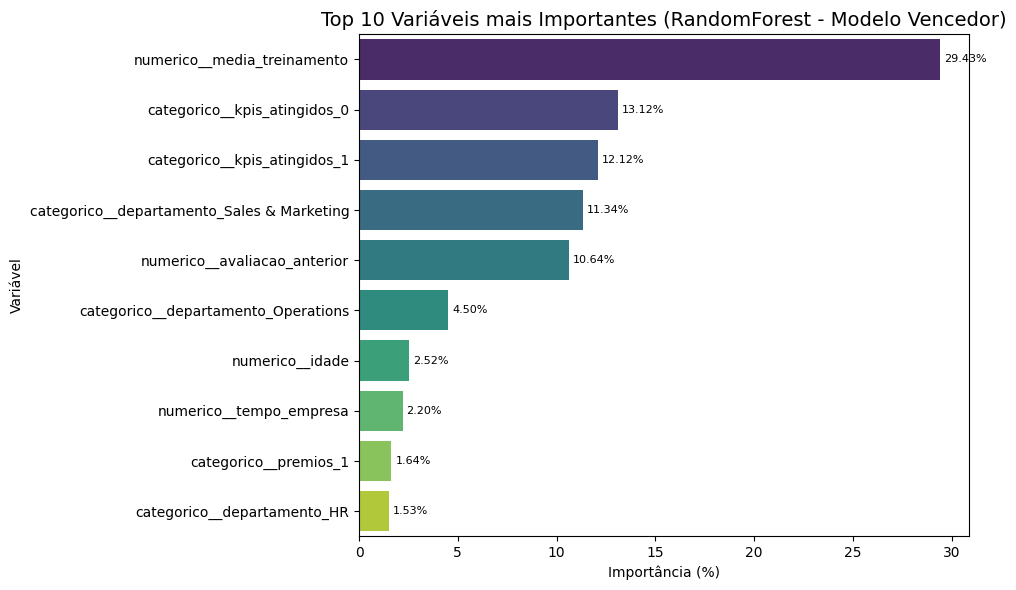

In [42]:
# ============================================================
# 19. Importância das variáveis (com visualização)
# ============================================================

modelo_final = pipeline_final_optuna.named_steps["modelo"]

# Pega o preprocessador e as features
preprocessador = pipeline_final_optuna.named_steps["preprocessador"]
nomes_features = preprocessador.get_feature_names_out()
# Extrai importâncias das features
importancias = modelo_final.feature_importances_
# Cria DataFrame com os dados
df_importancia = pd.DataFrame({
    "feature": nomes_features,
    "importancia": importancias
}).sort_values(by="importancia", ascending=False).reset_index(drop=True)
# Normaliza em percentual
df_importancia["importancia_pct"] = 100 * df_importancia["importancia"] / df_importancia["importancia"].sum()
df_importancia["importancia_acumulada"] = df_importancia["importancia_pct"].cumsum()
# Seleciona top 10
top_n = 10
df_top = df_importancia.head(top_n)
# --- Gráfico ---
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_top,
    x="importancia_pct",
    y="feature",
    hue="feature",
    palette="viridis",
    dodge=False,
    legend=False
)
# Adiciona os valores no gráfico
for i, v in enumerate(df_top["importancia_pct"]):
    plt.text(v + 0.2, i, f"{v:.2f}%", va="center", fontsize=8)
plt.title(f"Top {top_n} Variáveis mais Importantes (RandomForest - Modelo Vencedor)", fontsize=14)
plt.xlabel("Importância (%)")
plt.ylabel("Variável")
plt.tight_layout()
plt.show()

In [43]:
# Tabela com as 10 variáveis com maior importância

df_top[["feature", "importancia_pct", "importancia_acumulada"]].style.hide(axis="index")

feature,importancia_pct,importancia_acumulada
numerico__media_treinamento,29.425252,29.425252
categorico__kpis_atingidos_0,13.116535,42.541786
categorico__kpis_atingidos_1,12.116498,54.658284
categorico__departamento_Sales & Marketing,11.339519,65.997803
numerico__avaliacao_anterior,10.643622,76.641426
categorico__departamento_Operations,4.504294,81.145719
numerico__idade,2.519837,83.665557
numerico__tempo_empresa,2.201298,85.866855
categorico__premios_1,1.639768,87.506622
categorico__departamento_HR,1.534851,89.041473


✅ **Insights sobre as feature importances**:

- O modelo apresentou influência orientada a variáveis de desempenho e engajamento (como KPIs, treinamentos e avaliações anteriores), bem como algumas
variáveis demográficas (idade) e organizacionais (departamento, tempo de empresa).
- Importância acumulada das Top 10 features: aproximadamente 90% — indicando que o modelo tem boa concentração de explicabilidade em um conjunto reduzido de variáveis

### 📊 Análise Final do Modelo de Classificação Vencedor: Random Forest

**Threshold --> 0.5**: manter o threshold no limiar padrão apresentou ser a melhor escolha, visando o objetivo do projeto, que era minimizar o custo com erros reduzidos para Falsos Negativos, reduzindo perda de talentos.

---

#### 🔍 Avaliação Geral do Modelo

| Métrica        | Valor        | Interpretação                                                                 |
|----------------|--------------|------------------------------------------------------------------------------|
| **Recall (classe 1)** | 0.9475       | O modelo consegue identificar quase em totalidade os promovidos reais. Isso era meu principal objetivo. |
| **F2 Score**    | 0.5683       | A métrica F2 prioriza o recall e reforça a capacidade do modelo em identificar talentos. |
| **AUC-PR**      | 0.5720       | A precisão da classe 0 está baixa, no entanto, para a classe 1 ficou excelente. O intuito de se ter um modelo com recall priorizado para a classe 1 já previa que isso possivelmente aconteceria. |
| **AUC-ROC**     | 0.9001       | Apresenta um ótimo resultado separação entre classes, indicando que o modelo tem boa capacidade discriminativa. |

---

#### 📌 Interpretação da Matriz de Confusão

|                | Predito: Não promovido | Predito: Promovido |
|----------------|------------------------|---------------------|
| **Real: Não promovido** | 0.68 (TN)              | 0.32 (FP)          |
| **Real: Promovido**     | 0.05 (FN)              | 0.95 (TP)          |

- O modelo identificou **95% dos promovidos reais**, o que confirma o alto recall.
- No entanto, **32% dos não promovidos foram classificados como promovidos**, o que pode gerar ruídos ou expectativas indevidas
- Além disso, apenas **5% dos promovidos reais**, o modelo classificou como **não promovidos**, sendo um leve e aceitável risco ao que o objetivo propõe

---

#### 📈 Curva Precision-Recall (AUC = 0.5720)

- Esta curva mostra o equilíbrio entre **precisão** e **recall**.
- A área abaixo da curva (**AUC-PR**) demonstra um equilíbrio que podemos considerar como aceitável, uma vez que indica que o modelo **acerta muitos promovidos**, mas **erra também, mesmo que com menor frequência**.
- Aqui percebo que o modelo **traz alguns falsos positivos**, comprometendo (principalmente para a classe 1) a **precisão**, mesmo que em contrapartida tenha um ótimo **recall** para esta mesma classe.

---

#### 📈 Curva ROC (AUC = 0.9001)

- A curva ROC mostra a relação entre **taxa de verdadeiros positivos (TPR / recall)** e a **taxa de falsos positivos (FPR)**.
- O modelo apresenta uma excelente **AUC-ROC de 0.9001**, o que indica uma **excelente capacidade de discriminar entre as classes**.
- No entanto, é preciso considerar que essa métrica da **ROC é menos sensível ao desbalanceamento**, até por isso, neste caso se torna mais prudente considerar com maior importância a métrica analisada via **precision-recall**.

---

#### 📊 Distribuição das Probabilidades

- O gráfico de distribuição de probabilidades apresentou uma boa separação entre as classes: a maioria dos não promovidos recebeu probabilidades baixas (próximas de 0), enquanto os promovidos estão mais concentrados acima de 0.5, evidenciando que o modelo consegue distinguir bem os casos mais claros.
- O threshold padrão de 0.5 se mostra adequado, uma vez que grande parte dos promovidos está acima desse valor
- Apesar disso, como o resultado apresentou, ainda há uma faixa intermediária (próximo a 0.4) onde ocorre sobreposição entre as classes, possivelmente pelo fato de que em alguns casos o perfil dos candidatos pode não ser tão claramente distinto pelo modelo
- Quanto aos falsos negativos (representados pelas barras verdes à esquerda do threshold: probabilidade < 0.50), é o risco assumido pelo modelo, sendo candidatos que deveriam ser promovidos, mas que o modelo não identificou corretamente
- Os falsos positivos (representados pelas barras cinzas à esquerda do threshold: probabilidade < 0.50) se apresentam em alta proporção, considerando um risco assumido e um papel de ser um modelo que auxiliará o time de negócios (RH), sendo necessário ferramentas e métodos auxiliares para a tomada de decisão, sendo assim uma solução que apoiará os profissionais, com orientação direcionada à dados

---

#### ✅ Conclusões e Próximos Passos

- O modelo está **adequado para uma estratégia que visa o contexto/objetivo em que, perder um promovido é mais custoso do que promover alguém indevidamente**. Desta forma, este modelo prevê sua utilização como uma **ferramenta de apoio à decisão**, e não como critério absoluto de promoção.
- Portanto, o mais correto e coerente é **validar o impacto com o RH ou líderes**, para verificar a aplicabilidade do modelo proposto ao ambiente corporativo, validando assim se o recall alto realmente ajuda a **não perder talentos valiosos**.
- Desta forma, poderíamos resumir que este poderia ser um uso aplicado como parte de um **sistema de recomendação de candidatos internos**, sempre associado à avaliação humana.

In [47]:
# ============================================================
# 20. Aplicar pipeline final sem undersampling para produção e salvamento do joblib
# ============================================================

pipeline_final_producao = Pipeline(steps=[
    ("transforma_tipos", transforma_tipos),
    ("transforma_variaveis", transforma_variaveis),
    ("preprocessador", preprocessador),
    ("modelo", melhor_modelo)
])

# Treina o pipeline final com todo o dataset
pipeline_final_producao.fit(X, y)
joblib.dump(pipeline_final_producao, "modelo_final.pkl")
print("Pipeline salvo com sucesso!")

Pipeline salvo com sucesso!


# Predição Final (Dados Simulando Ambiente de Produção)

In [48]:
# ============================================================
# 21. Carregando pipeline e gerando a Predição Final 
# ============================================================

# Carregando o modelo
pipeline_carregado = joblib.load("modelo_final.pkl")
y_pred = pipeline_carregado.predict(df_teste)
y_proba = pipeline_carregado.predict_proba(df_teste)[:, 1]

print("Predições feitas com o threshold embutido:", y_pred)

resultado_final = pd.DataFrame({
    "matricula": df_teste["matricula"],
    "promovido": y_pred
})

resultado_final.to_csv("predicoes_threshold.csv", index=False)

Predições feitas com o threshold embutido: [1 0 0 ... 0 0 1]


In [49]:
# ============================================================
# 22. DataFrame final com probabilidades e predições para análise
# ============================================================

df_resultado = df_teste.copy()
df_resultado["prob_promocao"] = y_proba
df_resultado["promovido"] = y_pred

df_resultado.head(50)

,matricula,departamento,regiao,escolaridade,genero,canal_recrutamento,qtd_treinamentos,idade,avaliacao_anterior,tempo_empresa,kpis_atingidos,premios,media_treinamento,prob_promocao,promovido
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,NaN,1,1,0,77,0.69,1
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.00,5,0,0,51,0.00,0
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.00,4,0,0,47,0.00,0
3,38562,Procurement,region_2,Bachelor's,f,other,3,31,2.00,9,0,0,65,0.03,0
4,64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4.00,7,0,0,61,0.08,0
5,46232,Procurement,region_7,Bachelor's,m,sourcing,1,36,3.00,2,0,0,68,0.03,0
6,54542,Finance,region_2,Bachelor's,m,other,1,33,5.00,3,1,0,57,0.56,1
7,67269,Analytics,region_22,Bachelor's,m,sourcing,2,36,3.00,3,0,0,85,0.24,0
8,66174,Technology,region_7,Master's & above,m,other,1,51,4.00,11,0,0,75,0.04,0
9,76303,Technology,region_22,Bachelor's,m,sourcing,1,29,5.00,2,1,0,76,0.73,1


## Analisando proporção dos Promovidos

In [50]:
# ===============================
# 25. Proporção dos Promovidos
# ===============================

pd.set_option('display.float_format', '{:.4f}'.format)
print(f"\n=== (DF Resultado - Predição Final) ===")
print(df_resultado['promovido'].value_counts(normalize=True))
print(f"\n=== (DF Treino - Dados Originais) ===")
df_treino['promovido'].value_counts(normalize=True)


=== (DF Resultado - Predição Final) ===
promovido
0   0.6523
1   0.3477
Name: proportion, dtype: float64

=== (DF Treino - Dados Originais) ===


promovido
0   0.9148
1   0.0852
Name: proportion, dtype: float64

In [51]:
# ===============================
# 26. Função para comparar distribuições de promovidos e teste estatísticos qui-quadrado com principais indicadores
# ===============================

def analisar_indicador_completo(df_treino, df_resultado, indicador):    

    def adicionar_labels_percentual(eixo):
        for contorno in eixo.containers:
            for barra in contorno:
                altura = barra.get_height()
                if altura > 0:
                    eixo.annotate(f'{altura:.0%}',
                                  xy=(barra.get_x() + barra.get_width() / 2, barra.get_y() + altura / 2),
                                  ha='center', va='center', fontsize=9, color='white', weight='bold')

    figura, eixos = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    plt.suptitle(f'Indicador: {indicador}', fontsize=16, weight='bold')

    resultados = {}

    for i, (df, nome_df, eixo) in enumerate(zip([df_treino, df_resultado], ['Treino', 'Resultado'], eixos)):
        print(f"\n--- Análise: {indicador} ({nome_df}) ---")

        # Tabela cruzada
        tabela_frequencia = pd.crosstab(df[indicador], df['promovido']) 

        # Proporção por categoria
        tabela_proporcao = pd.crosstab(df[indicador], df['promovido'], normalize='index')

        # Teste Qui-quadrado
        qui2, p_valor, graus_liberdade, esperada = chi2_contingency(tabela_frequencia)
        print(f"\n📊 Teste Qui-Quadrado:")
        print(f"Chi2 = {qui2:.4f}, p-value = {p_valor:.4f}, DOF = {graus_liberdade}")
        if p_valor < 0.05:
            print("🚨 Diferença significativa detectada nas distribuições!")
        else:
            print("✅ Sem diferença estatisticamente significativa.")

        # Preparar dados para o gráfico
        dados_grafico = tabela_proporcao.reset_index().melt(
            id_vars=indicador, var_name='Promovido', value_name='Proporcao'
        )

        # Gráfico de barras empilhadas
        sns.barplot(data=dados_grafico, x=indicador, y='Proporcao', hue='Promovido', ax=eixo)
        eixo.set_title(f'{nome_df} (p = {p_valor:.4f})')
        eixo.set_ylabel('Proporção')
        eixo.set_xlabel(indicador)

        # Ajuste da rotação dos rótulos
        for rotulo in eixo.get_xticklabels():
            rotulo.set_rotation(30)
            rotulo.set_ha('right')

        eixo.legend(title='Promovido')
        adicionar_labels_percentual(eixo)

        # Armazenar os resultados
        resultados[nome_df] = {
            'chi2': qui2,
            'p_value': p_valor,
            'graus_liberdade': graus_liberdade,
            'esperado': esperada,
            'tabela': tabela_frequencia,
            'proporcao': tabela_proporcao
        }

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    return resultados


===== Analisando: GENERO =====

--- Análise: genero (Treino) ---

📊 Teste Qui-Quadrado:
Chi2 = 6.6773, p-value = 0.0098, DOF = 1
🚨 Diferença significativa detectada nas distribuições!

--- Análise: genero (Resultado) ---

📊 Teste Qui-Quadrado:
Chi2 = 38.2642, p-value = 0.0000, DOF = 1
🚨 Diferença significativa detectada nas distribuições!


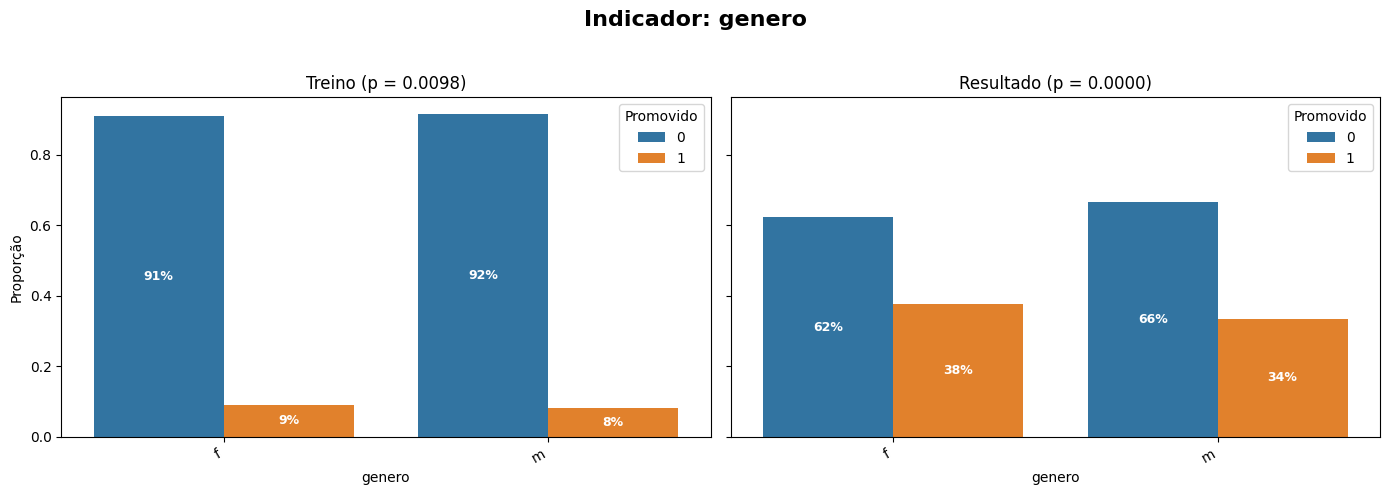


===== Analisando: ESCOLARIDADE =====

--- Análise: escolaridade (Treino) ---

📊 Teste Qui-Quadrado:
Chi2 = 36.7030, p-value = 0.0000, DOF = 2
🚨 Diferença significativa detectada nas distribuições!

--- Análise: escolaridade (Resultado) ---

📊 Teste Qui-Quadrado:
Chi2 = 13.7163, p-value = 0.0011, DOF = 2
🚨 Diferença significativa detectada nas distribuições!


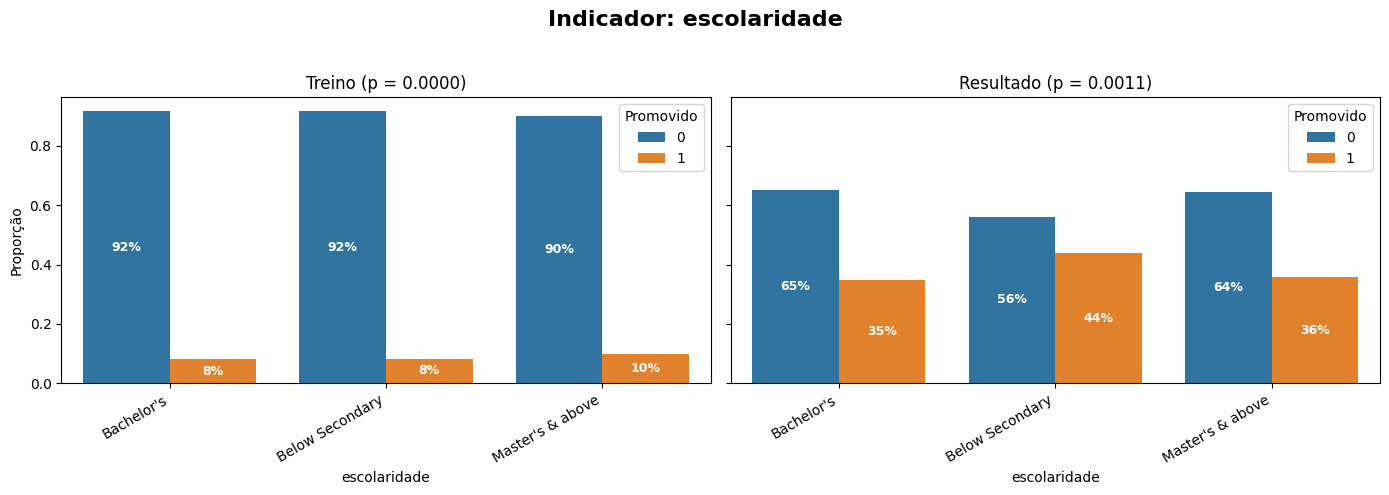


===== Analisando: AVALIACAO_ANTERIOR =====

--- Análise: avaliacao_anterior (Treino) ---

📊 Teste Qui-Quadrado:
Chi2 = 1464.5094, p-value = 0.0000, DOF = 4
🚨 Diferença significativa detectada nas distribuições!

--- Análise: avaliacao_anterior (Resultado) ---

📊 Teste Qui-Quadrado:
Chi2 = 4075.1376, p-value = 0.0000, DOF = 4
🚨 Diferença significativa detectada nas distribuições!


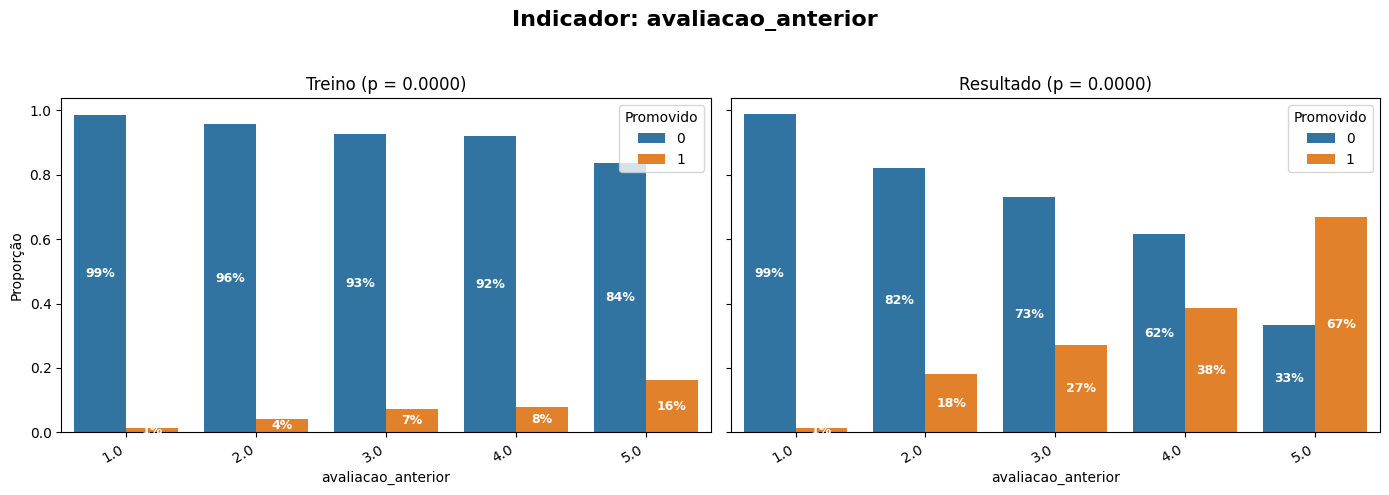


===== Analisando: KPIS_ATINGIDOS =====

--- Análise: kpis_atingidos (Treino) ---

📊 Teste Qui-Quadrado:
Chi2 = 2689.3221, p-value = 0.0000, DOF = 1
🚨 Diferença significativa detectada nas distribuições!

--- Análise: kpis_atingidos (Resultado) ---

📊 Teste Qui-Quadrado:
Chi2 = 17518.9209, p-value = 0.0000, DOF = 1
🚨 Diferença significativa detectada nas distribuições!


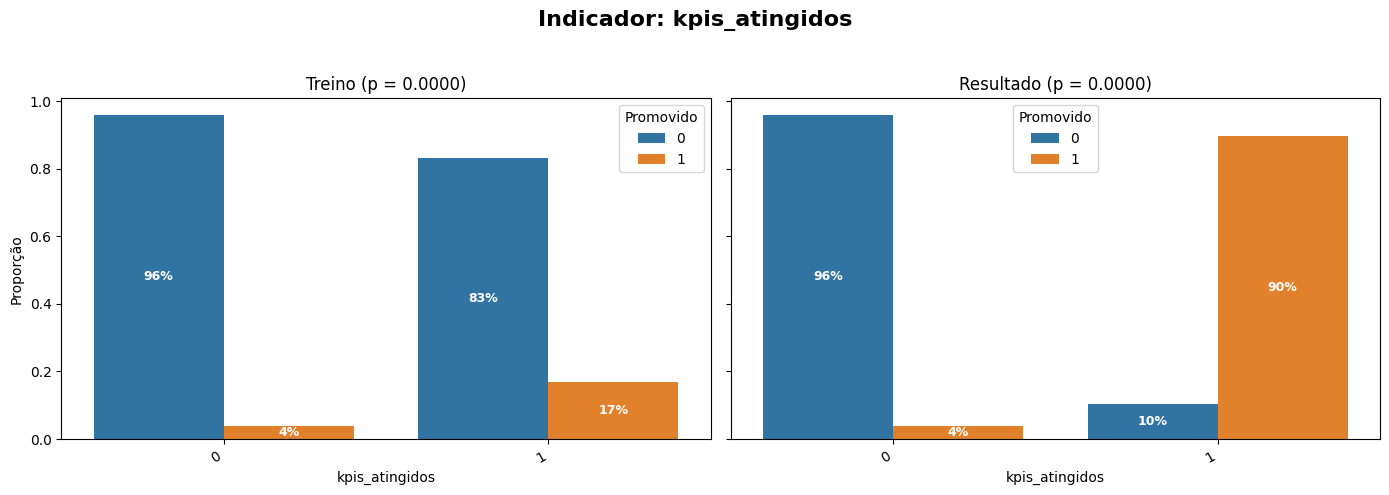


===== Analisando: PREMIOS =====

--- Análise: premios (Treino) ---

📊 Teste Qui-Quadrado:
Chi2 = 2098.0719, p-value = 0.0000, DOF = 1
🚨 Diferença significativa detectada nas distribuições!

--- Análise: premios (Resultado) ---

📊 Teste Qui-Quadrado:
Chi2 = 491.8294, p-value = 0.0000, DOF = 1
🚨 Diferença significativa detectada nas distribuições!


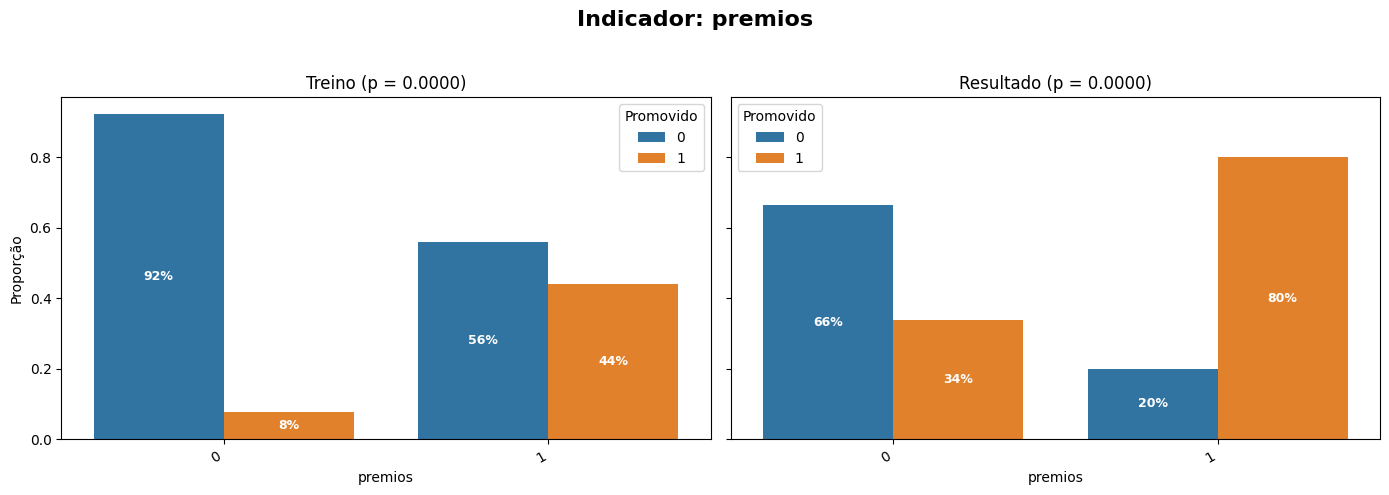

In [52]:
# ===============================
# 27. Visualizando comparações com indicadores sociodemográficos e de perfomance
# ===============================

'''Lista de indicadores categóricos sociodemográficos e performance'''

indicadores = ['genero', 'escolaridade', 'avaliacao_anterior', 'kpis_atingidos', 'premios']

resultados_finais = {}
for indicador in indicadores:
    print(f'\n===== Analisando: {indicador.upper()} =====')
    resultados_finais[indicador] = analisar_indicador_completo(df_treino, df_resultado, indicador)